# Tutorial de  Julia para Otimização
## Escola de Verão - EMap/FGV
## Aula 02 - Algoritmos de Otimização em Julia

### Ministrante
- Luiz-Rafael Santos ([LABMAC/UFSC/Blumenau](http://labmac.mat.blumenau.ufsc.br))
    * Email para contato: [l.r.santos@ufsc.br](mailto:l.r.santos@ufsc.br) ou [lrsantos11@gmail.com](mailto:lrsantos11@ufsc.br)
	- Repositório do curso no [Github](https://github.com/lrsantos11/Tutorial-Julia-Opt)


# Introdução à otimização
O problema geral de otimização (P) pode ser dado por

$$
\begin{align}
\min f(x)\tag{P}\\ 
\text{s.a. } \ell \leq c(x) \leq u
\end{align}
$$

em que $f:D_{f}\subset \mathbb{R}^n \to \mathbb{R}$ e $c:D_{c}\subset \mathbb{R}^n\to \mathbb{R}^m$.

* $f$ é *chamada função objetivo*

* Como $c(x) = (c_1(x),\ldots,c_m(x))$, então chamamos cada $c_i$ de *restrição*

* O conjunto $\Omega := \{x\in \mathbb{R}^n\mid \ell \leq c(x) \leq u$\} é *chamado conjunto viável* ou *factível*. 
  - Caso $\Omega = \mathbb{R}^n$ dizemos que (P) *irrestrito*
  - Caso $\Omega = \emptyset$, dizemos que (P) é *inviável* ou *infactível*

* Em particular, neste tutorial:
    * $f$ e cada $c_i$ serão $C^1(\mathbb{R})$ ($C^2(\mathbb{R}$) se necessário)
    
 

### Minimizadores


* Diremos que $x^*\in\Omega$ é um *minimizador (global)* do problema $P$ se 

$$f(x^*) \leq f(x), \forall x\in \Omega$$

* $x^*\in\Omega$ é um *minimizador local* do problema $P$ se existe $\delta>0$ tal que

$$f(x^*) \leq f(x), \forall x\in \Omega\cap \mathcal{B}_{\delta}(x^*)$$


### Métodos Iterativos

* Os métodos para resolver (P) são iterativos, isto é, vamos gerar computacionalmente uma sequência de pontos chamados *iterandos* $(x_k)_{k\geq 0}$ tal que a aproximação $x_{k+1}$ está bem definida quando
$$f(x_{k+1}) < f(x_k),$$
se 
$\nabla f(x_k)\neq 0$


> **Direção de descida.** Dizemos que $d\in \mathbb{R}^n$ é uma direção de descida a partir de $x$ se existe $\varepsilon>0$ tal que 
$$ f(x + \alpha d) < f(x)$$
para todo $\alpha \in (0,\varepsilon]$.

* Direções que formam ângulo menor que 90 graus com $\nabla f(x)$ são de descida
    * A direção $d = -\nabla f(x)$ é chamada *direção de máxima descida a partir de $x$*




### Condição de otimalidade

* Queremos gerar uma suquência tal que $x_k \to x^*$ ou tal que  $x_k \to \bar x$, em que $\bar x$ satisfaz alguma *condição de otimalidade*

* Neste tutorial não discutiremos com profundidade a teoria de  *Condições de Otimalidade* mas usaremos alguns resultados como o teorema a seguir. 

> **Teorema.** [Condição necessária de 1a ordem]
>     Seja $f:\mathbb{R}^n \to \mathbb{R}$ diferenciável no ponto $x^*$. Se $x^*$ é minimizador local de $f$, então
>    $$ \nabla f(x^*) = 0.$$

* Todo $x^*$ que cumpre a condição acima é chamado *ponto estacionário* ou *ponto crítico*

* Vamos implementar métodos que convergem (em princípio) para pontos estacionários.

### Algoritmo básico de otimização 

* Passo 0: 
    - escolha ponto inicial $x_0$; faça $k = 0$.

* Passo 1: 
     - se  $x_k$ está perto suficiente de um *ponto estacionário*, pare; caso contrário ($\nabla f(x_k)\neq 0$), vá ao Passo 2.

* Passo 2:
	- encontre direção $d_k$ de **descida** e tamanho de passo $\alpha_k$ tal que $f(x_k + \alpha_kd_k) < f(x_k)$

* Passo 3: 
	- compute	
     $$ x_{k+1} = x_k + \alpha_k d_k$$

* Passo 4: 
    - faça k = k+1 e volte ao Passo 1
     



# Dois métodos para minimizar quadráticas sem restrição

* Vamos  resolver  o seguinte problema quadrático irrestrito (QP)
$$\label{eq:quadratic}
\min_{x \in \mathbb{R}^{n}} f(x)=\frac{1}{2} x^{T} A x - b^{T} x + c.
$$
com $A\in\mathbb{R}^{n\times n}$ simétrica definida postiva.

* Note que 
$$ \label{eq:gradient}
\nabla f(x) = Ax-b 
$$





* Vamos seguir de perto o texto
> *Métodos computacionais de otimização* de J. Mário Martinez e Sandra A. Santos  (1995) [(PDF)](http://www.ime.unicamp.br/~martinez/mslivro.pdf).



In [1]:
using Pkg
pkg"activate ../."
pkg"resolve"
pkg"instantiate"

 Activating environment at `~/Documents/GitHub/tutorial-julia-opt/Project.toml`
No Changes to `~/Documents/GitHub/tutorial-julia-opt/Project.toml`
No Changes to `~/Documents/GitHub/tutorial-julia-opt/Manifest.toml`


In [2]:
using LinearAlgebra, Plots, Random

In [3]:
# Estrutura a e funções para a quadratica

struct Quadratica
     Q::Matrix
     b::Vector
     c::Number
     Quadratica(Q,b, c) = new(Q,b,c)
end

obj(quad::Quadratica,x::Vector) = .5*dot(x,quad.Q*x) - dot(quad.b,x) + quad.c;
grad(quad::Quadratica,x::Vector) = quad.Q*x - quad.b;

### Exemplo
$$
\min_{x \in \mathbb{R}^{n}} f(x)=\frac{1}{2} x^{T} Q x - b^{T} x + c
$$

$$
{Q}=\left[\begin{array}{ll}3 & 2 \\ 2 & 6\end{array}\right], {b}=\left[\begin{array}{r}2 \\ -8\end{array}\right], \quad {c}=0 \Rightarrow \mathbf{x}^*=\left[\begin{array}{r}2 \\ -2\end{array}\right]
$$

In [4]:
Q = Float64[3 2; 2 6];
b = Float64[2, -8];
xsol = Q\b;

In [5]:
quad = Quadratica(Q,b,0);
quad_R2(x,y) = obj(quad,[x,y]);
x = range(-4,stop=6,length = 100);
y = range(-6,stop=4,length = 100);
z = quad_R2.(x,y);

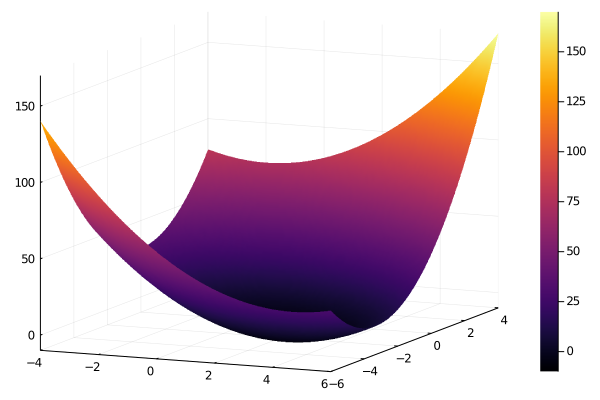

In [6]:
plt2 = surface(x,y,quad_R2)

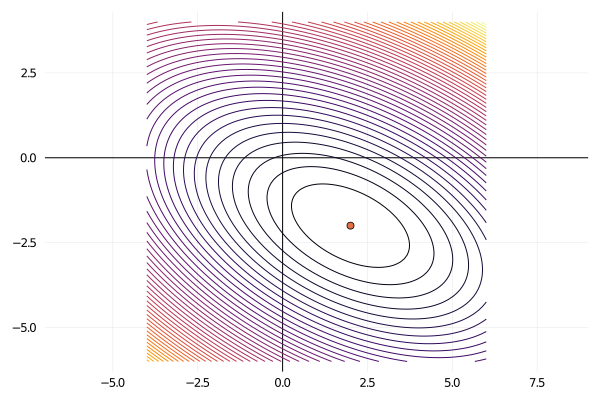

In [7]:
plt = contour(x,y,quad_R2,leg=false,framestyle=:zerolines,levels=50,aspect_ratio=:equal)
scatter!(plt,[xsol[1]],[xsol[2]])

## Método de Máxima descida (ou gradientes descendentes ou Cauchy)

* No modelo geral, faremos $d_k = -\nabla f(x_k) = b-Qx$ e vamos calcular $\alpha_k$ tal que 
$$ \alpha_k = \operatorname{arg}\min_{\alpha\geq 0} \varphi(\alpha) = f(x_k + \alpha d_k)$$

* O valor de $\alpha_k$ é dado pela fórmula fechada (Por quê? - Exercício)

    $$ \alpha_k = \frac{d_k^Td_k}{d_k^TQd_k} \text{ }$$

* Direções de duas iterações consecutivas são ortogonais

* **Critério de parada**: $\| d_k\|$ pequena o suficiente

### Jogo da pesca de tesouro

* Clique [aqui](https://www.i-am.ai/apps/gradient-descent/index.html) para jogar


> Após jogar algumas vezes você já percebeu que a maneira mais rápida de encontrar o ponto mais profundo no fundo do oceano é prestando atenção na inclinação encontrada em cada vez que você joga seu equipamento: o quão descendente o fundo está e em que direção estava inclindado. Embora você não possa **ver** o fundo e não tenha uma visão completa de como ele é, a inclinação te sugere por onde contiuar a busca.




## Algoritmo Gradiente Descendente


* **Passo 0.** Defina $x^0$, $d^0 =  b - Qx^0$ e $k=0$
* **Passo 1.** Enquanto $d^k \neq 0$ faça
    * $
    \alpha_{k} = \frac{({d}^{k})^Td^k}{({d}^{k})^TQ {d}^{k}}
    $
    
    * ${x}^{k+1}={x}^{k}+\alpha_{k} {d}^{k}$
    
    * $d_{k+1} = d_k - \alpha_kQd_k$ (Por quê?)
    
    * $k = k+1$
    


In [8]:
function iter_gradient(xₖ, dₖ,dotdₖ, quad)
    """
    Iteração basica de GD
    Parâmetros:
    xₖ: iteração atual
    dₖ: direção atual
    dotdₖ: prod interno dₖ
    quad: quadratica de interesse
    """
    Qdₖ = quad.Q*dₖ
    
    αₖ = dotdₖ / dot(dₖ,Qdₖ)
    
    xₖ = xₖ +  αₖ*dₖ
    
    dₖ = dₖ - αₖ*Qdₖ
    
    dotdₖ = dot(dₖ,dₖ)

    return xₖ, dₖ, dotdₖ
end

function gradient(quad::Quadratica,x₀::Vector;itmax::Int = 10, ε::Float64 = 1e-6)
	"""
    Método de Gradientes descendentes
    Parâmetros:
    quad: Quadratica
    x₀: ponto inicial
    itmax: número max de iterçãoes de GD
    ε: tol
    """
    k = 0
    xₖ = x₀
    dₖ = - grad(quad,xₖ)
    dotdₖ = dot(dₖ,dₖ)
    X =  xₖ
    while k <= itmax && dotdₖ >= ε^2 # equivalente a norm(dₖ) <= ε
        xₖ, dₖ, dotdₖ = iter_gradient(xₖ, dₖ, dotdₖ, quad)
        X = hcat(X,xₖ)
		k += 1 # equivale a k = k + 1    
    end
    return X, k
end

gradient (generic function with 1 method)

In [9]:
x₀ = [-2.,-2]
itmax=30
X, k = gradient(quad,x₀,itmax=itmax)
@show norm(b - quad.Q*X[:,end])
@show k
X[:,end]

norm(b - quad.Q * X[:, end]) = 8.148877212842571e-7
k = 24


2-element Array{Float64,1}:
  1.9999997739908102
 -1.9999999999999998

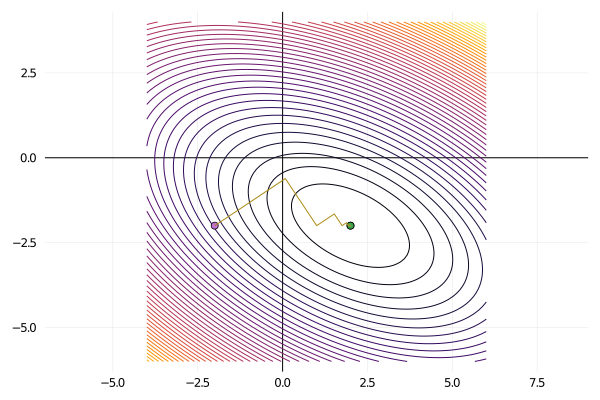

In [10]:
scatter!(plt,[xsol[1]],[xsol[2]])
scatter!(plt,[x₀[1]],[x₀[2]])
plot!(plt,X[1,:],X[2,:],st=:path)

## Método dos Gradientes Conjugados

## Eliminado o erro em $n$ passos

O erro gerado por uma sequência $({x}^{k})_{k\geq 0}$ em relação a solução $x^{*}$ de (QP) é dado por
$$
{e}^{k}={x}^{k}-{x}^{*}
$$
e o resíduo é dado por
$$
{r}^{k}= - \nabla f(x^k) = {b}-{Q} {x}^{k}.
$$

Substituindo (6) in (7) obtemos
$$
\begin{aligned}
{r}^{k}&={b}-{Q}\left({e}^{k}+{x}^{*}\right)=-{Q} {x}^{*}+{b}-{Q} {e}^{k}\\ &=-{Q} {e}^{k}
\end{aligned}
$$
representando a relação entre o erro e o resíduo.

Dado $x^{0}$, queremos definir uma sequência de $n$ direções (vetores) LI ${d}^{0}, \ldots, {d}^{n-1}$ então 
$$
\mathbb{R}^n = \mathcal{D}=\operatorname{span}\left({d}^{0}, \ldots, {d}^{n-1}\right)
$$
tais que 
$$\label{eq:xstra-x0}
{x}^{*}={x}^{0}+\sum_{i=0}^{n-1} \alpha{i} {d}^{i}. \tag{1}
$$
Vamos computar, de fato, cada passo 
$$
{x}^{k+1}={x}^{k}+\alpha_{k} {d}^{k}, \quad k=0, \ldots, n-1
$$
e como $\mathcal{D}$ é uma base de $\mathbb{R}^{n},$  vai existir a sequência de coeficientes
$$
\boldsymbol{\Phi}=\left(\alpha_{0}, \ldots, \alpha_{n-1}\right)
$$
que faz com que (1) esteja bem definido.

Pela definição de ${e}^{0}(:=x^{0}-x^{*} )$, temos
$$
{e}^{0}=-\sum_{i=0}^{n-1} \alpha_{i} {d}^{i}.
$$
* Nosso objetivo é eliminar o erro ${e}^{{0}},$ encontrando um conjunto   $\Phi$ e tomando os passos $\alpha_{k}$ para isso. 
*  Com isto  para obter ${x}^{*}$ apenas $n$ componentes de erro devem ser eliminadas
* Isto vai significar que o algoritmo finalizará com $n$ iterações.

##  Direções Ortogonais?
* Se escolhermos ${d}^{0}, \ldots, {d}^{n-1}$ ortogonais (i.e., $({d}^{i})^T {d}^{j} = \delta_{ij})$, teríamos mais facilidade para encontrar os $\alpha_k$'s? Vejamos

* Daí 
    $$
    ({d}^{k})^T{e}^{0}=-\sum_{i=0}^{n-1} \alpha_{i} ({d}^{k})^T{d}^{i}=- \alpha_{k}({d}^{k})^T {d}^{k}\implies \alpha_{k}=-\frac{({d}^{k})^T{e}^{0}}{({d}^{k})^T {d}^{k}},  k=0,\ldots,n-1 
$$

    * Como
$$
{e}^{k}={e}^{0}+\sum_{i=0}^{k-1} \alpha_{i} {d}^{i}, \: k=0, \ldots, n-1
$$
também obtemos
$$
\begin{aligned}
\alpha_{k} %- \frac{({d}^{k})^{T}\left({e}^{k}-\sum_{i=0}^{k-1} \alpha_{i} {d}^{i}\right)}{({d}^{k})^{T} {d}^{k}} \\
%&=-\frac{({d}^{k})^{T} {e}^{k}-\sum_{i=0}^{k-1} \alpha_{i} ({d}^{k})^{T} {d}^{i}}{({d}^{k})^{T} {d}^{k}}\\
& = -\frac{({d}^{k})^{T} {e}^{k}}{({d}^{k})^{T} {d}^{k}}, \quad k=0, \ldots, n-1
\end{aligned}
  $$  
* **Problema:** Não conhecemos os erros $e_k$ (Por quê?)

## Direções $Q$-conjugadas (ou $Q$-ortogonais)

* Se escolhermos agora ${d}^{0}, \ldots, {d}^{n-1}$ *$Q$-conjugadas*, i.e.,
    $$({d}^{i})^T Q {d}^{j} = 0\text{ se } i\neq j,$$ 
     conseguiremos computar os $\alpha_k$'s
* Vejamos 
    $$
    ({d}^{k})^TQ{e}^{0}=-\sum_{i=0}^{n-1} \alpha_{i} ({d}^{k})^TQ{d}^{i}= -\alpha_{k}({d}^{k})^TQ {d}^{k}$$
    e logo
    $$\alpha_{k}=-\frac{({d}^{k})^T(Q{e}^{0})}{({d}^{k})^TQ {d}^{k}} = \frac{({d}^{k})^Tr^0}{({d}^{k})^TQ {d}^{k}},  k=0,\ldots,n-1 
$$

* Da mesma forma como nas direções ortogonais temos
    
    $$
    \begin{aligned}
\alpha_{k} %&=- \frac{({d}^{k})^{T}Q\left({e}^{k}-\sum_{i=0}^{k-1} \alpha_{i} {d}^{i}\right)}{({d}^{k})^{T}Q {d}^{k}} \\
%&=-\frac{({d}^{k})^{T} Q{e}^{k}-\sum_{i=0}^{k-1} \alpha_{i} ({d}^{k})^{T}Q {d}^{i}}{({d}^{k})^{T} Q{d}^{k}}\\
& = -\frac{({d}^{k})^{T} Q{e}^{k}}{({d}^{k})^{T} {d}^{k}} = \frac{({d}^{k})^Tr^k}{({d}^{k})^TQ {d}^{k}}, \quad k=0, \ldots, n-1
\end{aligned}
  $$  
* Note que sempre é possível computar $r^k ( = b-Qx^k = -\nabla f(x^k))$!

## Algoritmo CG
* **Passo 0.** Defina $x^0$, $d^0 = r^0 = b - Qx^0$ e $k=0$
* **Passo 1.** Enquanto $r^k = b- Qx^k \neq 0$ faça
    * $
    \alpha_{k} = \frac{({d}^{k})^Tr^k}{({d}^{k})^TQ {d}^{k}}
    $
    * ${x}^{k+1}={x}^{k}+\alpha_{k} {d}^{k}$
    
    * $k = k+1$
    

## Como encontrar direções conjugadas $d^k$' s?


### Vamos usar resíduos para computar as direções conjugadas
* Atualizamos o próximo resíduo usando o resíduo anterior
$$
\begin{aligned}
{r}^{k+1} &=-{Q} {e}^{k+1} \\
&=-{Q} (x^{k+1} - x^*) \\
&=-{Q} ({x}^{k}+\alpha^{k} {d}^{k} - x^*) \\
&=-{Q}\left({e}^{k}+\alpha^{k} {d}^{k}\right) \\
&={r}^{k}-\alpha^{k} {Q} {d}^{k}, \:  k=0, \ldots, n-1
\end{aligned}
$$

* O próximo resíduo ${r}^{k+1} $ é uma combinação linear do resíduo atual ${r}^{k} $ e de $ {Q} {d}^{k}$

* Através dos ${r}^{0}, \ldots, {r}^{k}$ calcularemos as direções conjugadas ${d}^{0}, \ldots, {d}^{k}$ 

## Algoritmo CG

* **Passo 0.** Defina $x^0$, $d^0 = r^0 = b - Qx^0$ e $k=0$
* **Passo 1.** Enquanto $r^k \neq 0$ faça
    * $
    \alpha_{k} = \frac{({d}^{k})^Tr^k}{({d}^{k})^TQ {d}^{k}}
    $
    * $    {x}^{k+1}={x}^{k}+\alpha_{k} {d}^{k}$
    
    * ${r}^{k+1} = {r}^{k}-\alpha^{k} {Q} {d}^{k}$
    
    * $    k = k+1$
    

> * **Proposição.**
>$$ \mathcal{D}_{k}:=\operatorname{span}\left\{{d}^{0}, \ldots, {d}^{k}\right\}=\operatorname{span}\left\{{r}^{0}, \ldots, {r}^{k}\right\}, \:k=0, \ldots, n-1 $$
<!--- * Como ${r}^{k+1}={r}^{k}-\alpha_{k} {A} {d}^{k}$ e além disso ${d}^{k} \in \mathcal{D}_{k}$ e ${r}^{k} \in \mathcal{D}_{k}$ então
$$
\begin{aligned}
\mathcal{D}_{k+1} &:=\operatorname{span}\left\{\mathcal{D}_{k}, {r}^{k+1}\right\} \\
&=\operatorname{span}\left\{\mathcal{D}_{k}, {r}^{k}-\alpha_{k} {A} {d}^{k}\right\} \\
&=\operatorname{span}\left\{\mathcal{D}_{k}, {A} {d}^{k}\right\}
\end{aligned}
$$ --->


> **Lema.** $r^{k+1} \perp \mathcal{D}_k = \operatorname{span}\left\{{d}^{0}, \ldots, {d}^{k}\right\}=\operatorname{span}\left\{{r}^{0}, \ldots, {r}^{k}\right\}, \:k=0, \ldots, n-1$

> **Teorema.** $\mathcal{D}_{k} =\operatorname{span}\left\{{r}^{0}, {Q} {r}^{0}, {Q}^{2} {r}^{0}, \ldots, {Q}^{k} {r}^{0}\right\}, \: k=0, \ldots, n-1$
     
* O subepsaçco da direita  é o *subespaço de Krylov de dimensão k+1* dado por $Q$ e $r^0$ e é denotado por  $\mathcal{K}_{k+1}(Q,r^0)$

> **Corolário.** $r^{k}\perp_A\mathcal{D}_{k-2}$, para $k=0, \ldots, n-1$, isto é, $r^{k}$ é $A$-conjugado à $d^j$, $j<k-2$.

#### Consequência importante


* Se o resíduo $r^{k}$ é conjugado às direções  ${d}^{0}, \ldots, {d}^{k-2}$, então, a cada passo, por calcular o resíduo, já geramos um vetor que é  $Q$-orthogonal a todas as direções anteriores com exceção de  ${d}^{k-1}$. 

* Para obter a direção  ${d}^{k}$, que seja conjugada com as anteriores, tomamos o resíduo ${r}^{k}$ e o fazemos   $Q$-orthogonal à ${d}^{k-1}$. 

* Precisamos apenas encontrar o coeficiente  $\beta_{k-1}$ que corresponde à ${d}^{k-1}$ ao fazermos Gram-Schimidt com produto interno dado por $Q$:
$$
\begin{aligned}
{d}^{k} &={r}^{k}+\beta_{k-1} {d}^{k-1} \\
\implies 0 = ({d}^{k})^{T} {Q} {d}^{k-1} &=({r}^{k})^{T} {Q} {d}^{k-1}+\beta_{k-1} ({d}^{k-1})^{T} {Q} {d}^{k-1} \\
\implies \beta_{k-1} &=-\frac{({r}^{k})^{T} {Q} {d}^{k-1}}{({d}^{k-1})^T {Q} {d}^{k-1}}
\end{aligned}
$$

### Forma prática do CG

* Fazendo $k = k-1$ obtemos (usando ${d}^{k} ={r}^{k}+\beta_{k-1} {d}^{k-1}$)
$$
  \alpha_{k} = \frac{({d}^{k})^Tr^k}{({d}^{k})^TQ {d}^{k}} = \frac{(r^k)^Tr^k}{({d}^{k})^TQ {d}^{k}}
$$

$$
\beta_{k}=-\frac{({r}^{k+1})^{T} {Q} {d}^{k}}{({d}^{k})^T {Q} {d}^{k}} = \frac{({r}^{k+1})^{T} {r}^{k+1}}{({r}^{k})^T {r}^{k}}
$$

## Algoritmo CG


* **Passo 0.** Defina $x^0$, $d^0 = r^0 = b - Qx^0$ e $k=0$
* **Passo 1.** Enquanto $r^k \neq 0$ faça
    * $
    \alpha_{k} = \frac{({r}^{k})^Tr^k}{({d}^{k})^TQ {d}^{k}}
    $
    * $  {x}^{k+1}={x}^{k}+\alpha_{k} {d}^{k}$
    
    * ${r}^{k+1} = {r}^{k}-\alpha_{k} {Q} {d}^{k}$
    
    * $\beta_{k}=  \frac{({r}^{k+1})^{T} {r}^{k+1}}{({r}^{k})^T {r}^{k}}$
    
    *  ${d}^{k+1} ={r}^{k+1}+\beta_{k} {d}^{k}$
    
    * $    k = k+1$
    

In [27]:
function iter_CG(k, xₖ, rₖ, dotrₖ,dₖ, quad)
    """
    Iteração basica de CG
    Parâmetros:
    xₖ: iteração atual
    rₖ: residuo atual
    dotrₖ: prod interno rₖ
    dₖ: direção atual
    quad: quadratica de interesse
    """
    Qdₖ = quad.Q * dₖ; 
    αₖ = dotrₖ / dot(dₖ, Qdₖ);
    xₖ .+= αₖ * dₖ;
    if mod(k,50) ≠ 0
        rₖ .-= αₖ * Qdₖ;
    else
        rₖ = - grad(quad, xₖ);
    end
    βₖ = dot(rₖ, rₖ) / dotrₖ;
    dₖ = rₖ + βₖ * dₖ; 
    dotrₖ = dot(rₖ, rₖ);
    
    return xₖ, rₖ, dotrₖ, dₖ
    
end

function CG(quad::Quadratica,x₀::Vector;itmax::Int = 10,ε::Float64 = 1e-8)
       """
    Método de Gradientes Conjugados
    Parâmetros:
    quad: Quadratica
    x₀: ponto inicial
    itmax: número max de iterçãoes de CG
    ε: tolerância
     """
    xₖ = x₀
    rₖ = -grad(quad,xₖ)
    dₖ = copy(rₖ)
    k = 0
    X = xₖ 
    dotrₖ = dot(rₖ,rₖ)
    while k <= itmax && norm(rₖ) >= ε
        xₖ, rₖ, dotrₖ, dₖ = iter_CG(k, xₖ, rₖ, dotrₖ, dₖ, quad);
        X = hcat(X, xₖ)
        k += 1;    
    end
    return X, k
end

CG (generic function with 1 method)

(X, k) = CG(quad, x₀, itmax = itmax) = ([0.08000000000000007 0.08000000000000007 2.0; -0.6133333333333333 -0.6133333333333333 -2.0], 2)


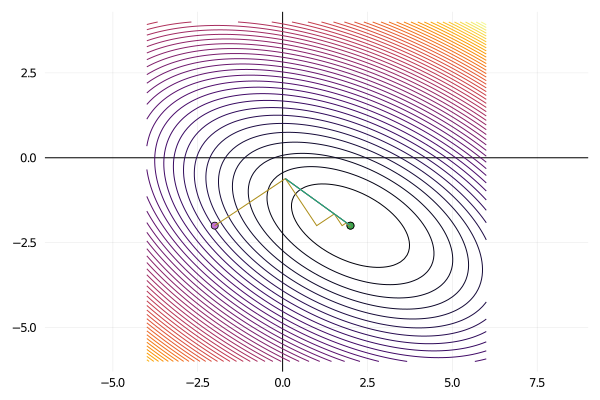

In [28]:
x₀ = [-2.,-2]
itmax=20
@show X, k = CG(quad,x₀,itmax=itmax)
plot!(plt,X[1,:],X[2,:],st=:path)

## Exemplos com `BigFloat` e matrizes maiores

In [12]:
pi

π = 3.1415926535897...

In [13]:
BigFloat(pi)

3.141592653589793238462643383279502884197169399375105820974944592307816406286198

#### Mesma matrix em $2\times 2$

In [30]:
x₀ = [-2.,-2];
quadbig = Quadratica(BigFloat.(Q),BigFloat.(b),0);
X, k = CG(quadbig,BigFloat.(x₀));
@show k
X[:,end]

k = 2


2-element Array{BigFloat,1}:
  2.0
 -1.999999999999999999999999999999999999999999999999999999999999999999999999999983

#### Matrix de tamnho grande

In [31]:
Random.seed!(1234)
N = 5000
B = randn(N,N)
B = 20*I + B'B
@show cond(B)
c = randn(N)
x₀ = randn(N)
quad2 = Quadratica(B,c,0)

cond(B) = 996.1270656020571


Quadratica([5108.490713350115 -161.16604059667353 … 20.01788612244853 -23.505142020523962; -161.16604059667353 4991.415426984541 … -90.0658069178206 -45.91028434193755; … ; 20.01788612244853 -90.0658069178206 … 5161.15567756138 50.214899249297495; -23.505142020523962 -45.91028434193755 … 50.214899249297495 4768.441310085535], [-0.966447047800183, -1.7100731305839536, 1.4338142488223287, -0.006746424620267033, -0.16515187761342426, -2.0185246286643364, -0.4736641118376779, -1.0174982832518966, -1.6947345686681257, 0.5469401112032765  …  -0.8553701256698236, 0.600059029497568, -0.07334233684553575, -1.0658737349954854, 0.6619701929775442, 1.0125435702902787, 0.09475945671909565, 0.45617806694482005, -0.5495477007463256, 0.7107920741543874], 0)

In [32]:
X, k = CG(quad2,x₀,itmax=1000)
@show k
norm(c - quad2.Q*X[:,end])

k = 433


9.759214287565527e-9

## Métodos iterativos para minização não-linear

### E se a função não for quadrática?

* **Exemplo**  Função de [Rosenbrock](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$f(x,y) = (a-x)^2 + b(y-x^2)^2$$

- Minimizador global em $(a,a^2)$ com $f(a,a^2) = 0$
    
* Considere o modelo quadrático dado por Taylor de 2ª ordem em torno de $x_k$ para $f$

$$ m_k(d) = f(x_k) + \nabla f(x_k)^Td + \frac{1}{2}d^T\nabla^2f(x_k)d$$

* O mínimo de $m_k$, (uma quadrática), se $\nabla^2f(x_k)$ for definida positiva é a única solução do sistema linear

$$ \nabla^2f(x_k)d = -\nabla f(x_k) $$

#### Como calcular as derivadas?

* Pacote de diferenciação automática [`ForwardDiff.jl`](https://github.com/JuliaDiff/ForwardDiff.jl) para cômputo de $\nabla f(x)$ e $\nabla^2 f(x)$


In [33]:
pkg"add ForwardDiff"

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %

  Resolving package versions...
No Changes to `~/Documents/GitHub/tutorial-julia-opt/Project.toml`
No Changes to `~/Documents/GitHub/tutorial-julia-opt/Manifest.toml`


┌ Info: Precompiling ForwardDiff [f6369f11-7733-5829-9624-2563aa707210]
└ @ Base loading.jl:1278


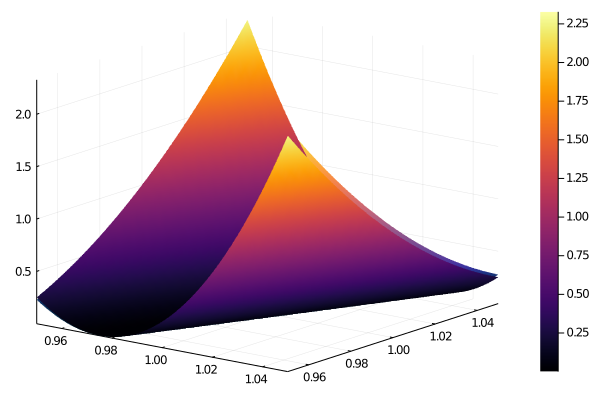

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/lucasmoschen/.julia/packages/Plots/lmp2A/src/backends/gr.jl:498


In [34]:
using ForwardDiff

f(x) = (1-x[1])^2 + 100 * (x[2] - x[1]^2)^2
∇f(x) = ForwardDiff.gradient(f, x)
H(x) = ForwardDiff.hessian(f, x)

x₀ = [1.0; 1.0]

mₖ(d) = f(x₀) + dot(∇f(x₀), d) + dot(H(x₀) * d, d) / 2
q(x) = mₖ(x - x₀)

a, b = 0.95,1.05
surface(
    range(a,b, length=50),
    range(a, b, length=50),
    (x,y) -> f([x;y]),
    linealpha = 0.3,
    fc=:thermal,
    camera = (40,40))
surface!(
    range(a, b, length=50),
    range(a, b, length=50),
    (x,y) -> q([x;y]),
)

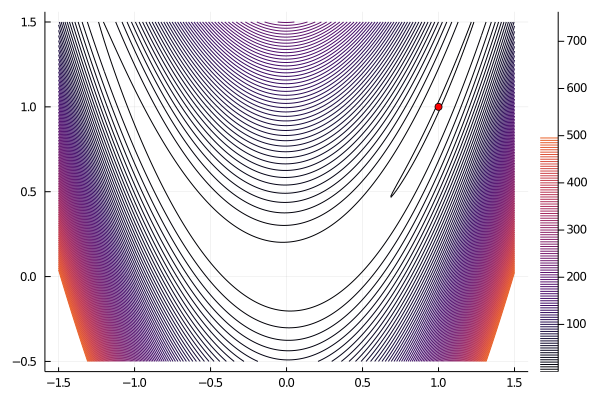

In [35]:
x = range(-1.5, 1.5, length=400)
y = range(-0.5 , 1.5, length=400)
contour(x,y,(x,y) -> f([x;y]),levels=0.1:5.0:500)
scatter!([1.0],[1.0],c=:red,label=:false)

## Método de Newton

### Newton para sistemas não-lineares

O método de Newton para encontrar uma solução $x^*$ do o sistema não-linear $F(x) = 0$, com $F:\mathbb{R}^n\to\mathbb{R}^n$, usa o polinômio de Taylor de 1ª ordem em torno de uma aproximação $\bar x$ obtendo o sistema linear

$$
F(\bar x) + J_F(\bar x) (x - \bar x) = F(x) = 0
$$

em que $J_F(\bar x)$ é a matriz jacobiana de $F$. 

Quando $J_F(\bar x)$ é não-singular podemos resolver o sistema linear acima pelo método iterativo

$$
x_{k+1} = x_k -  J_F(x^k)^{-1} F(x^k)
$$

### Método de Newton para Otimização

Como queremos encontrar ponto estacionário, isto é, $x^*$ tal que $\nabla f(x^*)=0$, fazendo $F = \nabla F$ obtemos o método iterativo

$$
x_{k+1} = x_k -  (\nabla^2f(x_k))^{-1} \nabla f(x_k)
$$

uma vez que $J_{\nabla f}(x) = \nabla^2f(x)$.

* A direção $d = -  (\nabla^2f(x_k))^{-1} \nabla f(x_k)$ é  exatamente a solução da minimização do modelo quadrático 

* Se $\nabla^2f(x)$ for definida positiva, a direção de Newton sempre é de descida. (Por quê?)

* Possivelmente precisamos computar um tamanho de passo $\alpha_k$ por busca linear exata (como no método de máxima descida) ou busca inexata (Passo de Armijo)


In [44]:
function newton(f, ∇f, H, x₀; itmax = 10_000, ε = 1e-6)
	k = 0;
    xₖ = x₀; 
    grad = ∇f(xₖ);
    while k <= itmax && norm(grad) >= ε
        d = - H(xₖ) \ grad
        xₖ += d;
        grad = ∇f(xₖ);
        k += 1
    end
    return xₖ, k
end

newton (generic function with 1 method)

In [45]:
x₀ = [1.25,1.1]
xsol, num_iter = newton(f, ∇f, H, x₀)

([1.0000000000000009, 1.000000000000002], 5)